## Imports :

In [1]:
# modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(15,8)})
from datetime import datetime, timedelta
from causalimpact import CausalImpact
import statsmodels.formula.api as smf

# helpers
from helpers.wiki_gtrend_visualization import load_wikipedia_df
from helpers.gtrend_visualization import load_gtrend_df, load_gtrend_hourly_df
from helpers.load_topic_hourly import request_gtrends

# Part 0: Data Pre-processing

In [2]:
tweets_df = pd.read_csv('data/tweets.csv', parse_dates=['date'], date_format='%Y-%m-%d %H:%M:%S')

This dataset contains all his tweets and retweets from 2009 to January, 8 2021 (one day before he was banned from Twitter) :

In [3]:
tweets_df.loc[1, 'date']

Timestamp('2020-03-03 01:34:50')

Let's focus on the Covid period:

In [4]:
tweets_covid_df = tweets_df[tweets_df['date'] >= '2019-12-01'].copy()
tweets_covid_df.sort_values(by='date')
tweets_covid_df.head()

,id,text,isRetweet,isDeleted,device,favorites,retweets,date,isFlagged
1,1234653427789070336,I was thrilled to be back in the Great city of...,f,f,Twitter for iPhone,73748,17404,2020-03-03 01:34:50,f
2,1218010753434820614,RT @CBS_Herridge: READ: Letter to surveillance...,t,f,Twitter for iPhone,0,7396,2020-01-17 03:22:47,f
3,1304875170860015617,The Unsolicited Mail In Ballot Scam is a major...,f,f,Twitter for iPhone,80527,23502,2020-09-12 20:10:58,f
4,1218159531554897920,RT @MZHemingway: Very friendly telling of even...,t,f,Twitter for iPhone,0,9081,2020-01-17 13:13:59,f
5,1217962723234983937,RT @WhiteHouse: President @realDonaldTrump ann...,t,f,Twitter for iPhone,0,25048,2020-01-17 00:11:56,f


# Part 1: Granger Causality

### A) Extract Relevant Tweets

Let's see the number of tweets where Hydroxychloroquine is mentioned.

In [5]:
# Pinpoint all tweets containing the key words
fake_news = ['Hydroxychloroquine', 'hydroxychloroquine']
analyze = tweets_covid_df['text'].apply(lambda x: True if any(word in x for word in fake_news) else False)

# Create a column with a boolean indicating whether tweet contains a key word
new_col = analyze.reindex(tweets_covid_df.index, fill_value=False)
tweets_covid_df['Hydroxychloroquine']=new_col

print('Number of tweets talking about Hydroxychloroquine is: ', tweets_covid_df['Hydroxychloroquine'].sum())

Number of tweets talking about Hydroxychloroquine is:  22


In [6]:
# Get the datetimes where trump spoke about Hydroxychloroquine
hydro_tweets_times = tweets_covid_df[tweets_covid_df['Hydroxychloroquine'] == True]['date'].copy()
hydro_tweets_times = hydro_tweets_times.reset_index(drop=True)
type(hydro_tweets_times)
hydro_tweets_times = hydro_tweets_times.dt.normalize() # set times to 00:00:00

### B) Plot Wiki Time Series

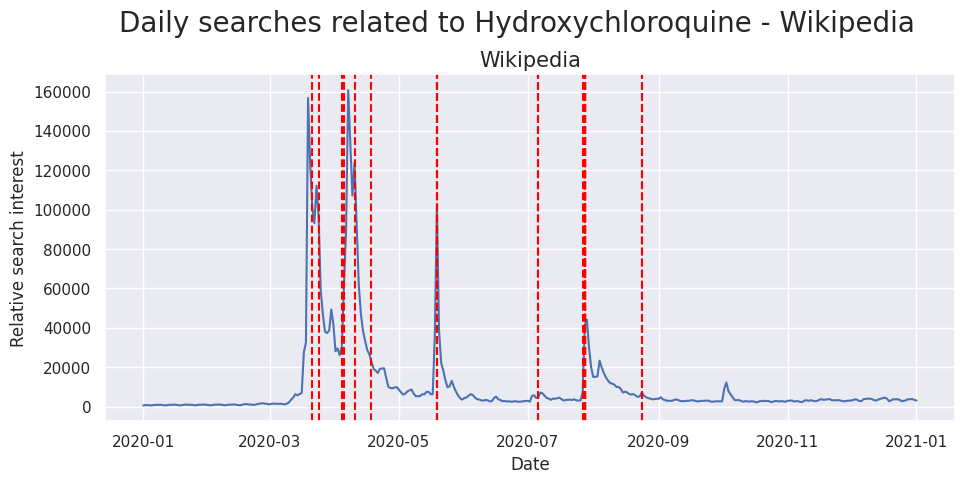

In [7]:
pagename = 'Hydroxychloroquine'
folder = 'data'
filename = 'hydroxychloroquine'

_, daily_wikipedia_hydro_df = load_wikipedia_df(folder,filename)

daily_wikipedia_hydro_df = daily_wikipedia_hydro_df.drop('Week', axis=1)

fig, axis = plt.subplots(figsize=(10,5))
fig.tight_layout(pad=3.0)

fig.suptitle('Daily searches related to {pagename} - Wikipedia'.format(pagename=pagename), size=20)
fig.subplots_adjust(top=0.85)

axis.set_title('Wikipedia', size=15)
axis.set_ylabel('Relative search interest')
axis.plot(daily_wikipedia_hydro_df['Views'])
[axis.axvline(x=critical_date, color='red', linestyle='--') for critical_date in hydro_tweets_times]

axis.set_xlabel('Date')

plt.show()

### C) Granger

In [8]:
# Put the tweets in a format compatible with Granger causality analysis (i.e. time series)
tweets_hydro_timeseries_df = pd.DataFrame(index=daily_wikipedia_hydro_df['Views'].index, columns=['Date'])

for date in hydro_tweets_times:
    tweets_hydro_timeseries_df[date] = (tweets_hydro_timeseries_df.index == date).astype(int)

tweets_hydro_timeseries_df['Date'].fillna(0, inplace=True)
tweets_hydro_timeseries_df['Tweet'] = tweets_hydro_timeseries_df.iloc[:, 1:].sum(axis=1)

# Combine wiki and tweets
wiki_tweets_hydro_df = daily_wikipedia_hydro_df.copy()
wiki_tweets_hydro_df['Tweets'] = tweets_hydro_timeseries_df['Tweet']
wiki_tweets_hydro_df['Tweets'].fillna(0, inplace=True)
display(wiki_tweets_hydro_df.sample(5))

,Views,Tweets
Date,,
2020-01-03,717,0
2020-04-12,61961,0
2020-02-19,1234,0
2020-04-04,30625,1
2020-03-15,6334,0


In [9]:
# Granger test between GTrends views and tweets
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests

print("DO VIEWS CAUSE TWEETS?")
grangercausalitytests(wiki_tweets_hydro_df, 2)

print('\n --------------------------------')
print("\n DO TWEETS CAUSE VIEWS?")
tweets_cause_views_gtrends = grangercausalitytests(wiki_tweets_hydro_df[['Tweets', 'Views']], 2)

DO VIEWS CAUSE TWEETS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0493  , p=0.8244  , df_denom=363, df_num=1
ssr based chi2 test:   chi2=0.0497  , p=0.8236  , df=1
likelihood ratio test: chi2=0.0497  , p=0.8236  , df=1
parameter F test:         F=0.0493  , p=0.8244  , df_denom=363, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.8660  , p=0.0082  , df_denom=360, df_num=2
ssr based chi2 test:   chi2=9.8671  , p=0.0072  , df=2
likelihood ratio test: chi2=9.7361  , p=0.0077  , df=2
parameter F test:         F=4.8660  , p=0.0082  , df_denom=360, df_num=2

 --------------------------------

 DO TWEETS CAUSE VIEWS?

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.1709 , p=0.0000  , df_denom=363, df_num=1
ssr based chi2 test:   chi2=18.3211 , p=0.0000  , df=1
likelihood ratio test: chi2=17.8773 , p=0.0000  , df=1
parameter F test:         F=18.1709 , p=0.0000  , df_denom=363, df_num=1

Granger Ca

# Part 2: Causal Impact

### A) Plot GTrends Time Series

Text(0.5, 21.249999999999993, 'Date')

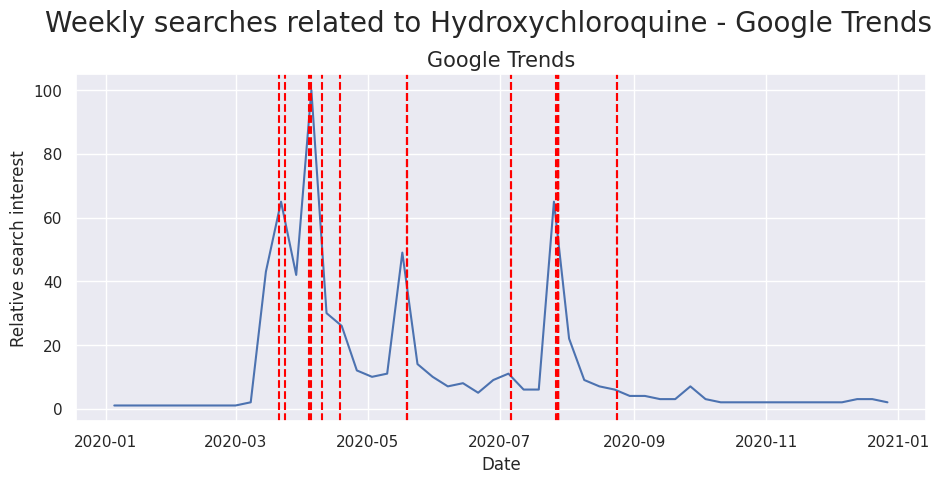

In [10]:
pagename = 'Hydroxychloroquine'
folder = 'data'
filename = 'hydroxychloroquine'

hydro_gtrends_df = load_gtrend_df(folder, filename)

fig, axis = plt.subplots(figsize=(10,5))
fig.tight_layout(pad=3.0)

fig.suptitle('Weekly searches related to {pagename} - Google Trends'.format(pagename=pagename), size=20)
fig.subplots_adjust(top=0.85)

axis.set_title('Google Trends', size=15)
axis.set_ylabel('Relative search interest')
axis.plot(hydro_gtrends_df['Views'])
[axis.axvline(x=critical_date, color='red', linestyle='--') for critical_date in hydro_tweets_times]

axis.set_xlabel('Date')

### B) Fetch GTrends Time Series at Hourly Granularity

In [11]:
# QUESTION (SABRI): SHOULD WE KEEP THIS IN THE NOTEBOOK?

# Select tweet number
tweet_nb = 0
alias = f"tweet_{tweet_nb}"

# Request data from GTrends API (both hydro and Google) and save it
tweet_time = hydro_tweets_times[tweet_nb].replace(minute=0, second=0)
print(f"Tweet time: {tweet_time}")
start_time = tweet_time - timedelta(hours=48)
end_time = tweet_time + timedelta(hours=48)

print(f"start time: {start_time}")
print(f"end time: {end_time}")

# Hydro data 
# folder = 'data'
# filename = 'hydroxychloroquine'
# pagename = 'Hydroxychloroquine'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# # Control data
# folder = 'data'
# filename = 'climate'
# pagename = 'Climate'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'coffee'
# pagename = 'Coffee'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'news'
# pagename = 'News'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'shop'
# pagename = 'Shop'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'time'
# pagename = 'Time'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

Tweet time: 2020-04-10 00:00:00
start time: 2020-04-08 00:00:00
end time: 2020-04-12 00:00:00


In [12]:
# Load hydro json
folder = 'data'
filename = 'hydroxychloroquine'
gtrends_hydro_df = load_gtrend_hourly_df(folder, filename, alias)

# Load control json
folder = 'data'
filename = 'climate'
gtrends_climate_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'coffee'
gtrends_coffee_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'news'
gtrends_news_df = load_gtrend_hourly_df(folder, filename, alias)
folder = 'data'
filename = 'shop'
gtrends_shop_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'time'
gtrends_time_df = load_gtrend_hourly_df(folder, filename, alias)

# Combine the dataframes
gtrends_df = pd.concat([gtrends_hydro_df, gtrends_climate_df, gtrends_coffee_df, 
                        gtrends_news_df, gtrends_shop_df, gtrends_time_df],
                         axis=1, keys=['hydro', 'climate', 'coffee', 'news',
                                        'shop', 'time'])
gtrends_df.columns = gtrends_df.columns.droplevel(1)

gtrends_df.head()

,hydro,climate,coffee,news,shop,time
Date,,,,,,
2020-04-08 12:00:00,66,50,76,100,63,65
2020-04-08 13:00:00,79,63,84,96,72,70
2020-04-08 14:00:00,84,66,81,95,78,76
2020-04-08 15:00:00,81,85,78,95,77,77
2020-04-08 16:00:00,86,95,75,99,73,72


### C) Causal Impact

In [13]:
# choose pre and post-periods
pre_period = [gtrends_df.index[0], tweet_time]
post_period = [tweet_time+timedelta(hours=1), gtrends_df.index[-1]]
print(pre_period)
print(post_period)

[Timestamp('2020-04-08 12:00:00'), Timestamp('2020-04-10 00:00:00')]
[Timestamp('2020-04-10 01:00:00'), Timestamp('2020-04-12 12:00:00')]


In [14]:
# Verify assumptions on pre-period: linear regression
mod = smf.ols(formula='hydro ~ coffee + climate + news + shop + time', data=gtrends_df[:pre_period[1]])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  hydro   R-squared:                       0.389
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     3.948
Date:                Mon, 18 Dec 2023   Prob (F-statistic):            0.00693
Time:                        16:11:46   Log-Likelihood:                -142.89
No. Observations:                  37   AIC:                             297.8
Df Residuals:                      31   BIC:                             307.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     18.1321     57.794      0.314      0.756     -99.740     136.004
coffee        -0.1510      0.494     -0.306      0.762      -1.159       0.857
climate        0.2138      0.149      1.433      0.162      -0.090       0.518
news           0.9127      0.342      2.671      0.012       0.216       1.610
shop          -0.8638      0.320     -2.700      0.011      -1.516      -0.211
time           0.3975      0.384      1.035      0.309      -0.386       1.181
==============================================================================
Omnibus:                        0.000   Durbin-Watson:                   0.970
Prob(Omnibus):                  1.000   Jarque-Bera (JB):                0.138
Skew:                          -0.003   Prob(JB):                        0.933
Kurtosis:                       2.701   Cond. No.                     4.92e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

[0, 36]


/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/causalimpact/main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/causalimpact/main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. Th

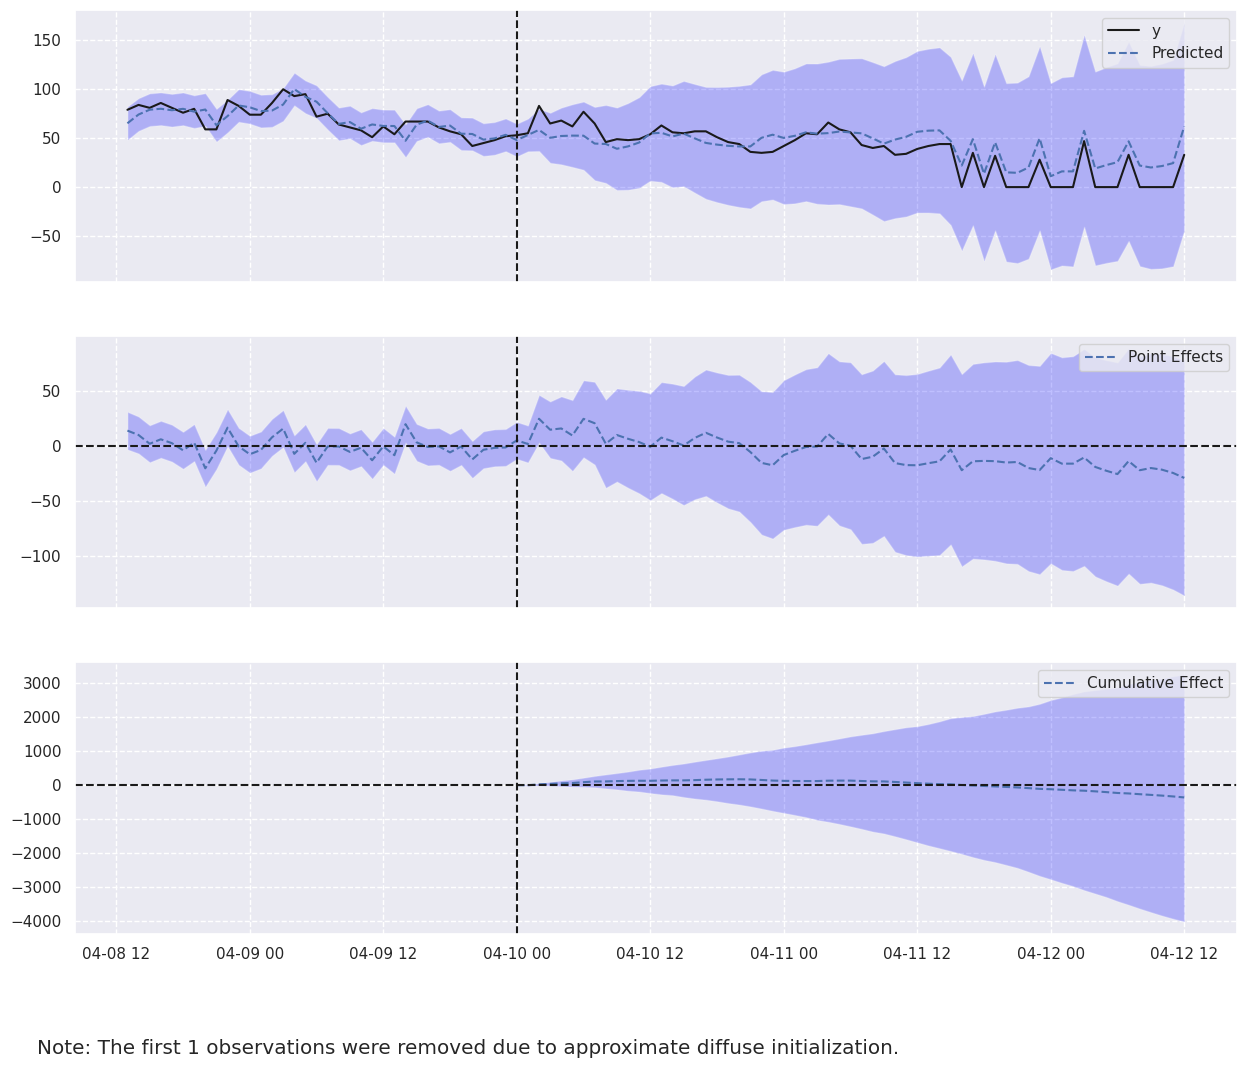

In [15]:
# conduct causal
impact = CausalImpact(data = gtrends_df, pre_period=pre_period, post_period=post_period, prior_level_sd=None, model_args={'dynamic_regression': True})
impact.plot()

### D) Alternative Hypothesis

In [16]:
# SABRI QUESTION: KEEP?
# Request data from GTrends API (both hydro and Google) and save it
treatment_time = pd.Timestamp(2020,3,16,18,0,0)
print(f"Tweet time: {treatment_time}")
start_time = pd.Timestamp(2020,3,15,12,0,0)
end_time = pd.Timestamp(2020,3,19,12,0,0)

print(f"start time: {start_time}")
print(f"end time: {end_time}")

alias = "publi"

# Hydro data 
# folder = 'data'
# filename = 'hydroxychloroquine'
# pagename = 'Hydroxychloroquine'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# # Control data
# folder = 'data'
# filename = 'climate'
# pagename = 'Climate'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'coffee'
# pagename = 'Coffee'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'news'
# pagename = 'News'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'shop'
# pagename = 'Shop'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

# folder = 'data'
# filename = 'time'
# pagename = 'Time'
# request_gtrends(folder, filename, alias, pagename, start_time, end_time)

Tweet time: 2020-03-16 18:00:00
start time: 2020-03-15 12:00:00
end time: 2020-03-19 12:00:00


In [17]:
# Load hydro json
folder = 'data'
filename = 'hydroxychloroquine'
gtrends_hydro_df = load_gtrend_hourly_df(folder, filename, alias)

# Load control json
folder = 'data'
filename = 'climate'
gtrends_climate_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'coffee'
gtrends_coffee_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'news'
gtrends_news_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'shop'
gtrends_shop_df = load_gtrend_hourly_df(folder, filename, alias)

folder = 'data'
filename = 'time'
gtrends_time_df = load_gtrend_hourly_df(folder, filename, alias)

display(gtrends_climate_df)
display(gtrends_coffee_df)

# Combine the dataframes
gtrends_df = pd.concat([gtrends_hydro_df, gtrends_climate_df, gtrends_coffee_df, 
                        gtrends_news_df, gtrends_shop_df, gtrends_time_df],
                         axis=1, keys=['hydro', 'climate', 'coffee', 'news',
                                        'shop', 'time'])
gtrends_df.columns = gtrends_df.columns.droplevel(1)

gtrends_df.head()

,Views
Date,
2020-03-15 12:00:00,30
2020-03-15 13:00:00,34
2020-03-15 14:00:00,40
2020-03-15 15:00:00,39
2020-03-15 16:00:00,39
...,...
2020-03-19 08:00:00,41
2020-03-19 09:00:00,48
2020-03-19 10:00:00,48


,Views
Date,
2020-03-15 12:00:00,74
2020-03-15 13:00:00,81
2020-03-15 14:00:00,87
2020-03-15 15:00:00,85
2020-03-15 16:00:00,82
...,...
2020-03-19 08:00:00,46
2020-03-19 09:00:00,49
2020-03-19 10:00:00,52


,hydro,climate,coffee,news,shop,time
Date,,,,,,
2020-03-15 12:00:00,2,30,74,61,85,63
2020-03-15 13:00:00,2,34,81,69,88,58
2020-03-15 14:00:00,1,40,87,60,85,66
2020-03-15 15:00:00,1,39,85,61,100,66
2020-03-15 16:00:00,1,39,82,59,86,63


In [18]:
# choose pre and post-periods
pre_period = [gtrends_df.index[0], treatment_time]
post_period = [treatment_time+timedelta(hours=1), gtrends_df.index[-1]]
print(pre_period)
print(post_period)

[Timestamp('2020-03-15 12:00:00'), Timestamp('2020-03-16 18:00:00')]
[Timestamp('2020-03-16 19:00:00'), Timestamp('2020-03-19 12:00:00')]


In [19]:
# Verify assumptions on pre-period: linear regression
mod = smf.ols(formula='hydro ~ coffee + climate + news + shop + time', data=gtrends_df[:pre_period[1]])
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  hydro   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.446
Method:                 Least Squares   F-statistic:                     5.833
Date:                Mon, 18 Dec 2023   Prob (F-statistic):            0.00106
Time:                        16:11:49   Log-Likelihood:                -37.945
No. Observations:                  31   AIC:                             87.89
Df Residuals:                      25   BIC:                             96.49
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.0069      2.701     -2.594      0.016     -12.570      -1.443
coffee         0.0148      0.022      0.670      0.509      -0.031       0.060
climate        0.0532      0.019      2.766      0.011       0.014       0.093
news           0.0516      0.018      2.801      0.010       0.014       0.090
shop           0.0213      0.027      0.776      0.445      -0.035       0.078
time           0.0037      0.022      0.164      0.871      -0.042       0.050
==============================================================================
Omnibus:                        6.749   Durbin-Watson:                   1.370
Prob(Omnibus):                  0.034   Jarque-Bera (JB):                2.202
Skew:                           0.211   Prob(JB):                        0.333
Kurtosis:                       1.765   Cond. No.                     2.54e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.54e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

[0, 30]


/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/causalimpact/main.py:603: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not data.applymap(np.isreal).values.all():
/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/causalimpact/main.py:302: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.mu_sig = (mu[0], sig[0])
/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/sabri/Anaconda3/envs/ada_project/lib/python3.9/site-packages/statsmodels/base/optimizer.py:18: FutureWarning: Keyword arguments have been passed to the optimizer that have no effect. Th

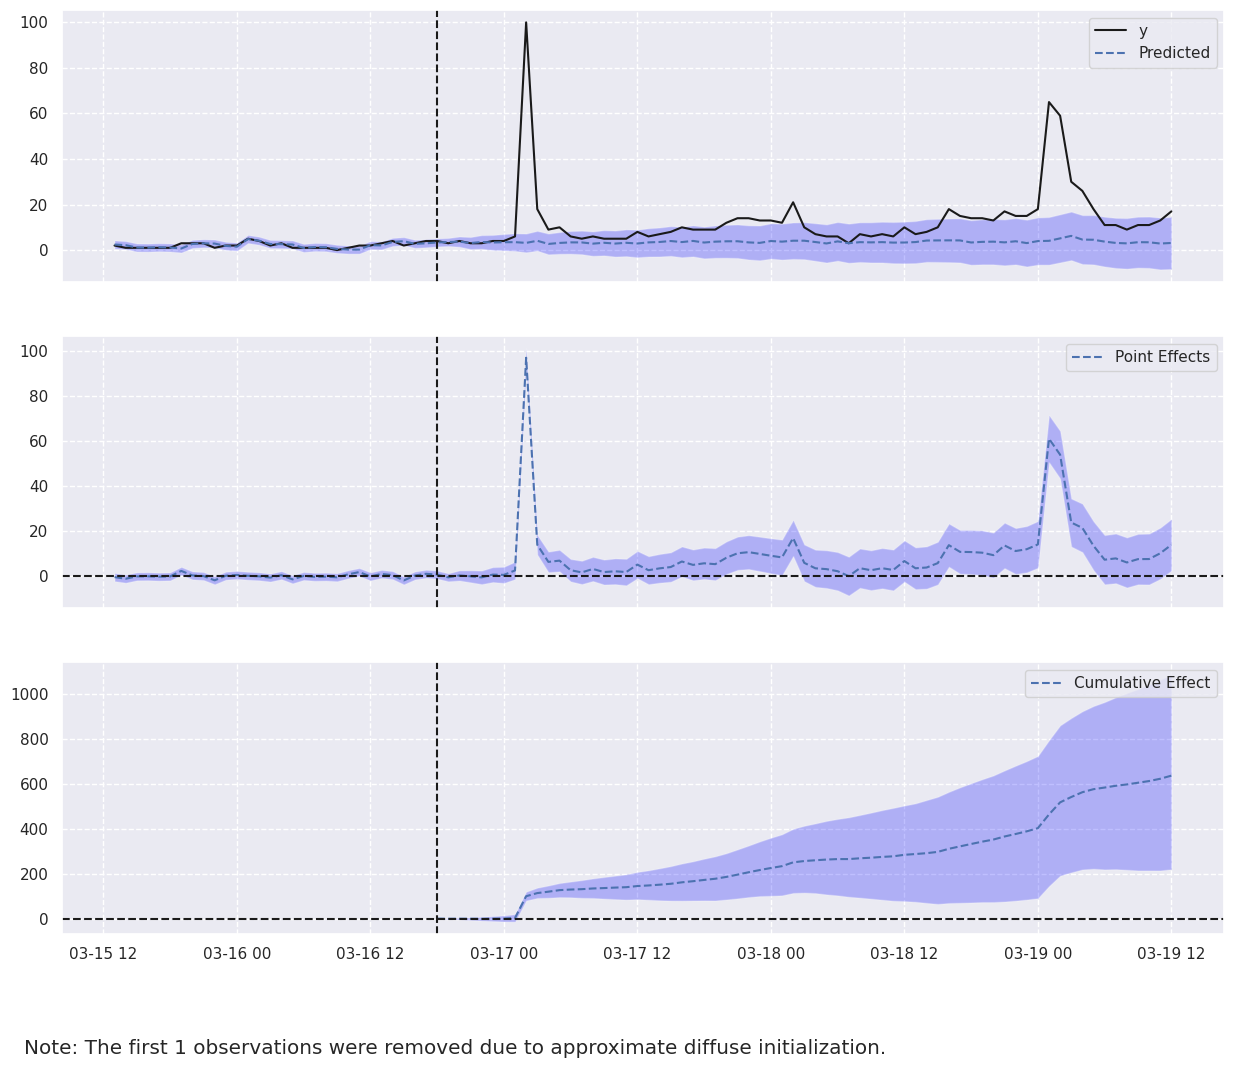

In [20]:
# conduct causal
impact = CausalImpact(data = gtrends_df, pre_period=pre_period, post_period=post_period, prior_level_sd=None, model_args={'dynamic_regression': True})
impact.plot()